# Pipeline for High-z Radio Galaxies 17: Radio detection classification with confirmed and predicted AGN

## Introduction

Training for classification of sources with and without radio detection in the HETDEX field. 

Sources are all elements detected in the CatWISE2020 catalogue.  But classification  
will be done with AGN from the Million Quasar Catalog (MQC) and those predicted  
to be AGN by the initial Galaxy/AGN classification model (`ML_01.ipynb`).  

Being either AGN or galaxy will be used as an additional feature.

Training data is from HETDEX Spring Field.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
from astropy.visualization import LogStretch, PowerStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve, RocCurveDisplay
from sklearn.metrics import matthews_corrcoef, precision_recall_curve, PrecisionRecallDisplay, auc
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
import sklearn.pipeline
import ppscore as pps
import seaborn as sns
import colorcet as cc
from pycaret import classification as pyc
# from pycaret import regression as pyr
from pycaret.internal.tabular import _get_columns_to_stratify_by
from joblib import dump, load
import pandas as pd

In [2]:
mpl.rcdefaults()

Create class to normalize asymmetric colorscales  
(from [http://chris35wills.github.io/matplotlib_diverging_colorbar/](http://chris35wills.github.io/matplotlib_diverging_colorbar/)).

In [3]:
class MidpointNormalize(mcolors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mcolors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

For future plots, we can configure their aspect too.

In [4]:
cmap           = cm.get_cmap('inferno')
cmap_alt       = cm.get_cmap('Dark2')
cmap_alt_2     = cm.get_cmap('Greys_r')  # Shades of grey
cmap_alt_3     = cm.get_cmap('coolwarm')  # blue to red
dark_color     = cmap(0.4)  # RGBA color code
light_color    = cmap(0.6)  # RGBA color code
colors         = [cmap(0.15), cmap(0.30), cmap(0.45), cmap(0.60), cmap(0.75), cmap(0.90)]
colors_3       = [cmap(0.25), cmap(0.50), cmap(0.75)]
colors_3_alt   = [cmap_alt(0.25), cmap_alt(0.50), cmap_alt(0.75)]
colors_3_alt_2 = [cmap_alt_2(0.25), cmap_alt_2(0.50), cmap_alt_2(0.75)]
colors_8       = [cmap(0.12), cmap(0.24), cmap(0.35), cmap(0.48), cmap(0.6), cmap(0.72), cmap(0.84), cmap(0.96)]
colors_8_alt   = [cmap_alt(0.12), cmap_alt(0.24), cmap_alt(0.35), cmap_alt(0.48), cmap_alt(0.6), cmap_alt(0.72),\
                  cmap_alt(0.84), cmap_alt(0.96)]
colors_8_alt_2 = [cmap_alt_2(0.06), cmap_alt_2(0.18), cmap_alt_2(0.29), cmap_alt_2(0.42), cmap_alt_2(0.54),\
                  cmap_alt_2(0.66), cmap_alt_2(0.78), cmap_alt_2(0.90)]
colors_8_alt_3 = [cmap_alt_3(0.06), cmap_alt_3(0.18), cmap_alt_3(0.29), cmap_alt_3(0.42), cmap_alt_3(0.54),\
                  cmap_alt_3(0.66), cmap_alt_3(0.78), cmap_alt_3(0.90)]

In [5]:
pe1            = [mpe.Stroke(linewidth=5.0, foreground='black'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]
pe2            = [mpe.Stroke(linewidth=3.0, foreground='white'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]

alp_str        = r'$\alpha$'

Methdods for PyCaret and saved models.

In [6]:
def get_final_column_names(pycaret_pipeline, sample_df):
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        for (name, method) in pycaret_pipeline.named_steps.items():
            if method != 'passthrough' and name != 'trained_model':
                print(f'Running {name}')
                sample_df = method.transform(sample_df)
        return sample_df.columns.tolist()
    else:
        for (name, method) in pyc.get_config('prep_pipe').named_steps.items():
            if method != 'passthrough' and name != 'trained_model':
                print(f'Running {name}')
                sample_df = method.transform(sample_df)
        return sample_df.columns.tolist()

In [7]:
def get_feature_importances_df(pycaret_pipeline, sample_df, n = 10):
    
    final_cols = get_final_column_names(pycaret_pipeline, sample_df)
    
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        try:
            variables = pycaret_pipeline["trained_model"].feature_importances_
            
        except:
            variables = np.mean([
                            tree.feature_importances_ for tree in pycaret_pipeline["trained_model"].estimators_
                if hasattr(tree, 'feature_importances_')
                            ], axis=0)
        
        coef_df = pd.DataFrame({'Feature': final_cols, 'Importance': variables})
        sorted_df = (
            coef_df.sort_values(by='Importance', ascending=False)
            .head(n)
            .sort_values(by='Importance', ascending=True).reset_index(drop=True)
        )
    else:
        try:
            variables = pycaret_pipeline.feature_importances_
            
        except:
            variables = np.mean([
                            tree.feature_importances_ for tree in pycaret_pipeline.estimators_
                if hasattr(tree, 'feature_importances_')
                            ], axis=0)
        
        coef_df = pd.DataFrame({'Feature': final_cols, 'Importance': variables})
        sorted_df = (
            coef_df.sort_values(by='Importance', ascending=False)
            .head(n)
            .sort_values(by='Importance', ascending=True).reset_index(drop=True)
        )
    return sorted_df

In [8]:
def plot_conf_mat(confusion_matrix, title, axin, display_labels=['Non true', 'True'], cmap='cet_dimgray_r', show_clb=False, log_stretch=False):
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix,
                              display_labels=display_labels)

    min_val_colour = np.nanmin(confusion_matrix)
    max_val_colour = np.nanmin(confusion_matrix)
    
    if log_stretch:
        norm = ImageNormalize(stretch=LogStretch())
    if not log_stretch:
        norm = ImageNormalize(stretch=PowerStretch(0.35))

    # NOTE: Fill all variables here with default values of the plot_confusion_matrix
    disp_b = disp.plot(include_values=True, cmap=cm.get_cmap(cmap),\
             ax=axin, xticks_rotation='horizontal')

    for text_val in disp_b.text_.flatten():
        text_val.set_fontsize(30)
    clb = plt.gca().images[-1].colorbar
    clb.ax.tick_params(labelsize=14)
    clb.ax.ticklabel_format(style='sci', scilimits=(0, 0))
    clb.outline.set_linewidth(2.5)
    clb.ax.set_ylabel('Elements in bin', size=14)
    if not show_clb:
        clb.remove()

    # disp_b.im_.set_clim(1e2, 3e3)
    disp_b.im_.norm = norm

    axin.xaxis.get_label().set_fontsize(16)
    axin.yaxis.get_label().set_fontsize(16)

    axin.tick_params(axis='both', which='major', labelsize=14)

    plt.setp(axin.spines.values(), linewidth=2.5)
    plt.setp(axin.spines.values(), linewidth=2.5)
    axin.set_title(title, fontsize=14)
    plt.tight_layout()

In [9]:
def MCC_from_CM(cm_array):  # Matthews correlation coefficient
    TN, FP, FN, TP = cm_array.flatten().astype('float32')
    MCC = ((TP * TN) - (FP * FN)) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
    return MCC

In [10]:
def ACC_from_CM(cm_array):  # Accuracy
    TN, FP, FN, TP = cm_array.flatten().astype('float32')
    ACC = (TP + TN) / (TP + TN + FP + FN)
    return ACC

In [11]:
def F1_from_CM(cm_array):  # F-1 score
    TN, FP, FN, TP = cm_array.flatten().astype('float32')
    F1 = 2 * TP / (2 * TP + FP + FN)
    return F1

In [12]:
def Recall_from_CM(cm_array):  # Recall
    TN, FP, FN, TP = cm_array.flatten().astype('float32')
    Recall = TP / (TP + FN)
    return Recall

In [13]:
def get_base_estimators_names(pycaret_pipeline):
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        estimators  = pycaret_pipeline['trained_model'].estimators
    else:
        estimators  = pycaret_pipeline.estimators

    estimators_list = [estimator[0] for estimator in estimators]
    return estimators_list

***

## Reading data

In [14]:
cat_path = '../../Catalogs/'  # relative path to the same directory

We import our data using the `pandas` package.

In [15]:
save_plot_flag         = False
save_model_flag        = False
use_AGN_gal_model_flag = False
load_model_flag        = True

In [16]:
# use_5sigma = True  # use files with 5-sigma magnitude imputation

In [17]:
mqc_version = '7_4d'  # '7_2'

In [18]:
file_name_train = f'CatWISE2020_VLASS_LOFAR_PS1_GALEX_TGSS_XMM_2MASS_MILLIQUAS_{mqc_version}_ALLWISE_LOLSS_SDSS_DR16_5sigma_imp.h5'  # 6729647 objects (6.7e6)

First, open the file as astropy Table to modify (and standardise)  
the units of fluxes and/or magnitudes.

---

Create `pandas` DataFrame from `astropy` table.

In [19]:
features_2_discard = ['objID', 'RA_ICRS', 'DE_ICRS', 'Name', 'RA_MILLI', 'DEC_MILLI',\
                     'TYPE', 'Z', 'zsp', 'X_ray_detect', 'Total_flux_VLASS', 'Sint_LOFAR',\
                      'Stotal_TGSS', 'FEP', 'TotalFlux_LoLSS', 'W1mag', 'W2mag', 'spCl', 'FUVmag', 'NUVmag'] # , 'mode',\
                     # 'class', 'f_zsp', 'subCl', 'zph', 'e_zph']  # Not needed for training in this model

In [20]:
full_catalog_df = pd.read_hdf(cat_path + file_name_train, key='df').drop(columns=features_2_discard)

In [21]:
# full_catalog_df.describe()

#### Load previous model to create labels for unknown sources (in general, do not use this).

In [22]:
confirmed_indices = full_catalog_df.loc[(full_catalog_df.loc[:, 'is_gal'] == 1) | (full_catalog_df.loc[:, 'is_AGN'] == 1)].index
unknown_indices   = full_catalog_df.drop(index=confirmed_indices).index
final_indices     = confirmed_indices.union(unknown_indices)  # all

In [23]:
print(f'There are {np.sum(full_catalog_df.loc[:, "is_AGN"] == 1):,} confirmed AGN in this dataset.')

There are 28,251 confirmed AGN in this dataset.


In [24]:
if use_AGN_gal_model_flag:
    AGN_gal_clf = pyc.load_model('models/classification_AGN_galaxy_may_15_2022')  # From ML_16.ipynb

In [25]:
if use_AGN_gal_model_flag:
    AGN_pred_threshold = 0.5
    new_labels_train   = pyc.predict_model(AGN_gal_clf, data=full_catalog_df,\
                                           probability_threshold=AGN_pred_threshold,\
                                           raw_score=True).loc[:, 'Score_1']

In [26]:
if use_AGN_gal_model_flag:
    full_catalog_df['class'] = new_labels_train.copy()

In [27]:
if use_AGN_gal_model_flag:
    full_catalog_df.loc[:, 'class'] = full_catalog_df.loc[:, 'class'].mask(full_catalog_df.loc[:, 'is_gal'] == 1, 0)
    full_catalog_df.loc[:, 'class'] = full_catalog_df.loc[:, 'class'].mask(full_catalog_df.loc[:, 'is_AGN'] == 1, 1)

#### Select only confirmed and highly likely AGN

In [28]:
if use_AGN_gal_model_flag:
    AGN_threshold = 0.95
    gal_threshold = 0.05

In [29]:
if use_AGN_gal_model_flag:
    filter_upgrade_AGN = (full_catalog_df.loc[:, 'class'] > AGN_threshold) & (full_catalog_df.loc[:, 'class'] < 1.00)
    filter_upgrade_gal = (full_catalog_df.loc[:, 'class'] < gal_threshold) & (full_catalog_df.loc[:, 'class'] > 0.00)
    full_catalog_df.loc[:, 'class'] = full_catalog_df.loc[:, 'class'].mask(filter_upgrade_AGN, 1)
    full_catalog_df.loc[:, 'class'] = full_catalog_df.loc[:, 'class'].mask(filter_upgrade_gal, 0)

In [30]:
if not use_AGN_gal_model_flag:
    full_catalog_df.loc[:, 'class'] = full_catalog_df.loc[:, 'is_AGN'].copy()

In [31]:
full_catalog_df.loc[:, 'class'] = full_catalog_df.loc[:, 'class'].astype(int)

## Possible correlations

In [32]:
print(full_catalog_df.columns.to_list())

['band_num', 'radio_detect', 'is_str', 'is_AGN', 'is_SDSS_gal', 'is_gal', 'W1mproPM', 'W2mproPM', 'gmag', 'rmag', 'imag', 'zmag', 'ymag', 'Jmag', 'Hmag', 'Kmag', 'W3mag', 'W4mag', 'g_r', 'g_i', 'g_z', 'g_y', 'g_J', 'g_H', 'g_K', 'g_W1', 'g_W2', 'g_W3', 'g_W4', 'r_i', 'r_z', 'r_y', 'r_J', 'r_H', 'r_K', 'r_W1', 'r_W2', 'r_W3', 'r_W4', 'i_z', 'i_y', 'i_J', 'i_H', 'i_K', 'i_W1', 'i_W2', 'i_W3', 'i_W4', 'z_y', 'z_J', 'z_H', 'z_K', 'z_W1', 'z_W2', 'z_W3', 'z_W4', 'y_J', 'y_H', 'y_K', 'y_W1', 'y_W2', 'y_W3', 'y_W4', 'J_H', 'J_K', 'J_W1', 'J_W2', 'J_W3', 'J_W4', 'H_K', 'H_W1', 'H_W2', 'H_W3', 'H_W4', 'K_W1', 'K_W2', 'K_W3', 'K_W4', 'W1_W2', 'W1_W3', 'W1_W4', 'W2_W3', 'W2_W4', 'W3_W4', 'class']


---

## Random seed

In [33]:
seed = 42

Create target

In [34]:
full_catalog_df.loc[:, 'radio_detect'] = full_catalog_df.loc[:, 'radio_detect'].astype(int)

## Split data: Test, Train, Validation

Create same train/test/validation sub-sets as with AGN/galaxy model.  
After this, select sources needed for this model (`class == 1`)

In [35]:
filter_known_spec = (full_catalog_df.loc[:, 'is_AGN'] == 1) | (full_catalog_df.loc[:, 'is_gal'] == 1)
full_catalog_df   = full_catalog_df.loc[filter_known_spec]
train_test_df, validation_df     = train_test_split(full_catalog_df, test_size=0.2,\
                                    random_state=seed, stratify=full_catalog_df.loc[:, 'class'])
train_df, test_df                = train_test_split(train_test_df, test_size=0.3,\
                                    random_state=seed, stratify=train_test_df.loc[:, 'class'])
print('Shape of used data in HETDEX')
print('(Confirmed galaxies and AGN)')
print('-' * 50)
print(f'Full confirmed dataset size:        {full_catalog_df.shape}')
print(f'Data for Modeling (Train and Test): {train_test_df.shape}')
print(f'Training data:                      {train_df.shape}')
print(f'Testing data:                       {test_df.shape}')
print(f'validation data:                    {validation_df.shape}')
print('-' * 50)
print()

Shape of used data in HETDEX
(Confirmed galaxies and AGN)
--------------------------------------------------
Full confirmed dataset size:        (83409, 85)
Data for Modeling (Train and Test): (66727, 85)
Training data:                      (46708, 85)
Testing data:                       (20019, 85)
validation data:                    (16682, 85)
--------------------------------------------------



In [36]:
full_catalog_df = full_catalog_df.loc[(full_catalog_df.loc[:, 'class'] == 1)]
train_test_df   = train_test_df.loc[(train_test_df.loc[:, 'class'] == 1)]
train_df        = train_df.loc[(train_df.loc[:, 'class'] == 1)]
test_df         = test_df.loc[(test_df.loc[:, 'class'] == 1)]
validation_df   = validation_df.loc[(validation_df.loc[:, 'class'] == 1)]

In [37]:
n_is_AGN = np.sum(full_catalog_df.loc[:, 'class'] == 1)
n_is_rad = np.sum(full_catalog_df.loc[:, 'radio_detect'] == 1)
print(f'In this dataset (HETDEX), with {len(full_catalog_df.loc[:, "is_AGN"]):,} elements,\n' +\
         f'{n_is_AGN:,} of them are marked as AGN, and, from them, {n_is_rad:,} have confirmed radio detection.')

In this dataset (HETDEX), with 28,251 elements,
28,251 of them are marked as AGN, and, from them, 8,518 have confirmed radio detection.


Remove intermediate targets

In [38]:
full_catalog_df = full_catalog_df.drop(columns=['is_AGN', 'is_SDSS_gal', 'is_gal', 'class', 'is_str'])
train_test_df   = train_test_df.drop(columns=['is_AGN', 'is_SDSS_gal', 'is_gal', 'class', 'is_str'])
train_df        = train_df.drop(columns=['is_AGN', 'is_SDSS_gal', 'is_gal', 'class', 'is_str'])
test_df         = test_df.drop(columns=['is_AGN', 'is_SDSS_gal', 'is_gal', 'class', 'is_str'])
validation_df   = validation_df.drop(columns=['is_AGN', 'is_SDSS_gal', 'is_gal', 'class', 'is_str'])

---

In [39]:
print('Final shape of used data')
print('-' * 50)
print('(Confirmed AGN)')
print('-' * 50)
print(f'Full confirmed dataset size:        {full_catalog_df.shape}')
print(f'Data for Modeling (Train and Test): {train_test_df.shape}')
print(f'Training data:                      {train_df.shape}')
print(f'Testing data:                       {test_df.shape}')
print(f'Validation data:                    {validation_df.shape}')
print('-' * 50)

Final shape of used data
--------------------------------------------------
(Confirmed AGN)
--------------------------------------------------
Full confirmed dataset size:        (28251, 80)
Data for Modeling (Train and Test): (22601, 80)
Training data:                      (15820, 80)
Testing data:                       (6781, 80)
Validation data:                    (5650, 80)
--------------------------------------------------


---

## Use Correlation matrix to discard some features

In [40]:
min_max_scaler              = MinMaxScaler(feature_range=(0., 1.))
full_scaled                 = min_max_scaler.fit_transform(train_test_df.values)
norm_train_test_df = pd.DataFrame(data=full_scaled, columns=train_test_df.columns, index=train_test_df.index)

Calculate Reduced Standard deviation to discard between pairs of features:  

$$\mathrm{RSD} = \frac{\sigma}{\mu} \times 100$$

In [41]:
rsd_vals = (train_test_df.std() / train_test_df.mean() * 100).sort_values(ascending=False)

In [42]:
rsd_vals

K_W3            624.424131
z_y             516.256644
i_z             326.853578
i_y             237.564569
r_i             173.388802
radio_detect    151.546369
r_y             144.427476
g_r             144.193405
r_z             143.625234
g_i             112.576827
g_y             107.516920
g_z             104.764871
W1_W2            91.869769
y_W1             67.729441
z_W1             59.368716
H_W3             58.563533
i_W1             53.996987
r_W1             52.870262
g_W1             52.824714
y_W2             52.603153
z_W2             45.878199
J_W3             45.081374
i_W2             41.339035
y_J              40.973477
g_W2             40.358603
r_W2             40.235013
y_H              37.844857
z_J              37.588309
i_J              35.690666
z_H              34.812818
W2_W3            34.482810
r_J              34.098272
i_H              33.172435
y_K              32.440916
W1_W3            32.249316
g_J              32.095223
r_H              31.849533
g

In [43]:
correlation    = norm_train_test_df.corr()

In [44]:
filt_high_corr = np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [45]:
corr_pairs     = correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_corr]

In [46]:
target_feat    = 'radio_detect'

In [47]:
list_drop_corr = []

We want to discard features that are highly correlated (>0.75).  
Between two features, we will discard the one with the lowest standard deviation (RSD).

In [48]:
for row in corr_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_corr:
        continue
    elif row[1] in list_drop_corr:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_corr.append(row[1])
        else:
            list_drop_corr.append(row[0])

In [49]:
list_drop_corr

['y_H',
 'g_H',
 'r_H',
 'z_H',
 'i_H',
 'J_W1',
 'J_W2',
 'y_K',
 'J_W3',
 'z_K',
 'i_K',
 'r_K',
 'g_K',
 'H_W1',
 'H_W2',
 'Jmag',
 'J_W4',
 'K_W1',
 'K_W2',
 'ymag',
 'zmag',
 'W1mproPM',
 'imag',
 'rmag',
 'gmag',
 'W2mproPM',
 'y_W4',
 'g_W4',
 'r_W4',
 'z_W4',
 'i_W4',
 'W1_W4',
 'Kmag',
 'W2_W4',
 'H_W3',
 'r_J',
 'g_W2',
 'J_K',
 'W1_W3',
 'r_W3',
 'i_J',
 'y_W3',
 'r_W2',
 'i_W3',
 'g_W3',
 'z_W3',
 'y_W2',
 'z_W2',
 'i_W2',
 'g_W1',
 'r_W1',
 'H_W4',
 'W3mag',
 'z_J',
 'Hmag',
 'i_W1',
 'g_y',
 'W3_W4',
 'r_y',
 'g_z',
 'g_J',
 'g_i']

In [50]:
# correlation.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

In [51]:
norm_train_test_discard = norm_train_test_df.drop(columns=list_drop_corr)

In [52]:
corr_discard = norm_train_test_discard.corr()

In [53]:
corr_discard.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

band_num  band_num    1.000000
z_y       i_y         0.737201
y_J       W2_W3       0.736708
band_num  y_J         0.728645
z_W1      y_W1        0.719265
W4mag     K_W3        0.688022
i_z       r_z         0.671493
K_W3      K_W4        0.636035
W2_W3     band_num    0.610033
r_i       r_z         0.571296
W4mag     K_W4        0.568049
K_W3      y_J         0.517616
band_num  H_K         0.485582
y_J       y_W1        0.467664
W1_W2     H_K         0.454817
dtype: float64

Text(1049.9166666666667, 0.5, 'feature')

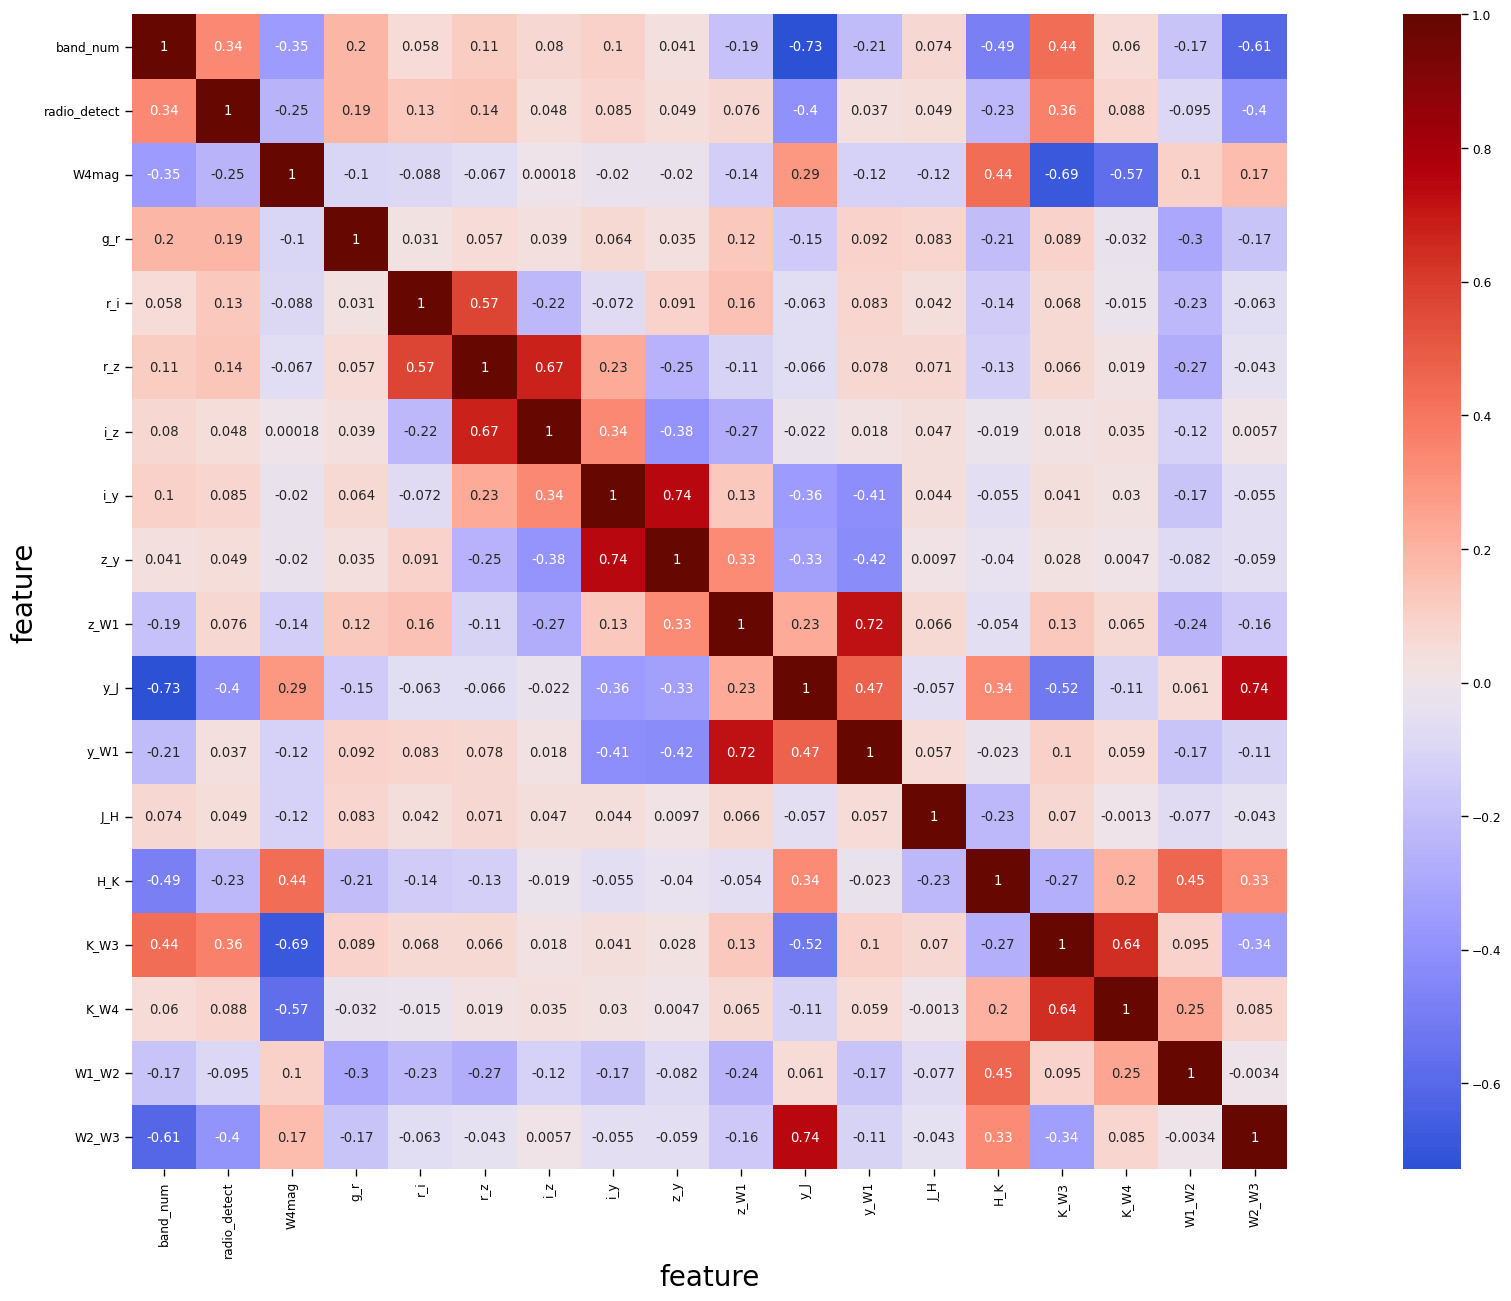

In [54]:
plt.figure(figsize=(30,15))
sns.set_context('paper', rc={'axes.labelsize':20, 'axes.ticklabelsize':14})
ax1 = sns.heatmap(corr_discard, annot=True, cmap=plt.get_cmap('cet_CET_D1A'), center=0.0, square=True)
ax1.set_xlabel('feature')
ax1.set_ylabel('feature')

In [55]:
norm_train_test_discard.loc[:, 'radio_detect'] = norm_train_test_discard.loc[:, 'radio_detect'].astype(bool)

In [56]:
pps_matrix = pps.matrix(norm_train_test_discard, random_seed=seed)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')

In [57]:
pps_matrix.unstack().sort_values(ascending=False).drop_duplicates()[:20]

x         y           
H_K       H_K             1.000000
band_num  y_J             0.583463
K_W4      W4mag           0.479233
J_H       H_K             0.377591
band_num  z_y             0.326286
K_W3      radio_detect    0.321808
band_num  W2_W3           0.295017
z_y       i_y             0.278370
y_J       band_num        0.263354
z_y       y_J             0.243914
band_num  radio_detect    0.229282
y_J       radio_detect    0.228483
K_W4      radio_detect    0.227825
K_W3      W4mag           0.226845
y_W1      z_W1            0.220211
band_num  i_y             0.220024
W2_W3     y_J             0.214692
          radio_detect    0.213441
K_W3      W2_W3           0.211814
y_J       W2_W3           0.209362
dtype: float64

In [58]:
filt_high_pps = np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [59]:
pps_pairs     = pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_pps]

In [60]:
target_feat = 'radio_detect'

In [61]:
list_drop_pps = []

In [62]:
for row in pps_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_pps:
        continue
    elif row[1] in list_drop_pps:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_pps.append(row[1])
        else:
            list_drop_pps.append(row[0])

In [63]:
list_drop_pps

[]

In [64]:
norm_train_test_discard = norm_train_test_discard.drop(columns=list_drop_pps)

In [65]:
pps_pred_target = pps.predictors(norm_train_test_discard, 'radio_detect', random_seed=seed)

In [66]:
pps_pred_target

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,K_W3,radio_detect,0.321808,classification,True,weighted F1,0.5908,0.722484,DecisionTreeClassifier()
1,band_num,radio_detect,0.229282,classification,True,weighted F1,0.5908,0.684622,DecisionTreeClassifier()
2,y_J,radio_detect,0.228483,classification,True,weighted F1,0.5908,0.684295,DecisionTreeClassifier()
3,K_W4,radio_detect,0.227825,classification,True,weighted F1,0.5908,0.684026,DecisionTreeClassifier()
4,W2_W3,radio_detect,0.213441,classification,True,weighted F1,0.5908,0.678140,DecisionTreeClassifier()
5,W4mag,radio_detect,0.202543,classification,True,weighted F1,0.5908,0.673681,DecisionTreeClassifier()
6,J_H,radio_detect,0.154699,classification,True,weighted F1,0.5908,0.654103,DecisionTreeClassifier()
7,H_K,radio_detect,0.146720,classification,True,weighted F1,0.5908,0.650838,DecisionTreeClassifier()
8,W1_W2,radio_detect,0.134055,classification,True,weighted F1,0.5908,0.645655,DecisionTreeClassifier()
9,r_i,radio_detect,0.080754,classification,True,weighted F1,0.5908,0.623844,DecisionTreeClassifier()


In [67]:
print(f'{len(full_catalog_df):,}')

28,251


---

## Use Machine Learning (ML): PyCaret

## Train Models

### AGN Detection Prediction

In [68]:
final_feats = pps_pred_target.x.to_list()  # Before Boruta

In [69]:
feats_2_discard = list_drop_corr + list_drop_pps

Boruta discards one feature.

In [70]:
exp_radio = pyc.setup(data=train_df, test_data=test_df, target='radio_detect', session_id=seed, silent=True,\
                      feature_selection=False, feature_selection_method='boruta', data_split_stratify=True,\
                      numeric_features=final_feats, ignore_features=feats_2_discard, transformation=True,\
                      transformation_method='yeo-johnson', n_jobs=12, normalize=True,\
                      normalize_method='zscore', use_gpu=False)  # 15 minutes with Boruta # 5 without

,Description,Value
0,session_id,42
1,Target,radio_detect
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(15820, 80)"
5,Missing Values,False
6,Numeric Features,17
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [71]:
pyc.get_config('X').columns

Index(['band_num', 'W4mag', 'g_r', 'r_i', 'r_z', 'i_z', 'i_y', 'z_y', 'z_W1',
       'y_J', 'y_W1', 'J_H', 'H_K', 'K_W3', 'K_W4', 'W1_W2', 'W2_W3'],
      dtype='object')

In [72]:
pyc.models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [73]:
metric_2_sort        = 'Recall'
final_selection_clf  = ['dt', 'rf', 'catboost', 'lightgbm', 'xgboost', 'dummy']  # lightgbm is selected to be base learner.
n_models             = 5
# top_model_radio = pyc.compare_models(n_select=n_models, include=final_selection_clf, sort=metric_2_sort)  # 1:15 hour for used_models_clf
top_model_radio = pyc.compare_models(n_select=n_models, exclude=['knn', 'qda', 'ridge', 'nb', 'svm'], sort=metric_2_sort)  # 10 minutes, using all models.

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.6882,0.6345,0.5025,0.4882,0.4951,0.2696,0.2698,0.1790
rf,Random Forest Classifier,0.7777,0.7986,0.4873,0.6917,0.5713,0.4274,0.4397,0.2580
catboost,CatBoost Classifier,0.7796,0.8076,0.4838,0.6995,0.5715,0.4298,0.4433,1.0910
lightgbm,Light Gradient Boosting Machine,0.7765,0.8045,0.4778,0.6926,0.5650,0.4215,0.4349,27.2090
xgboost,Extreme Gradient Boosting,0.7674,0.7881,0.4767,0.6644,0.5548,0.4031,0.4135,8.6170
et,Extra Trees Classifier,0.7733,0.7950,0.4678,0.6879,0.5564,0.4115,0.4256,0.1250
gbc,Gradient Boosting Classifier,0.7786,0.8051,0.4622,0.7095,0.5593,0.4203,0.4377,0.5690
ada,Ada Boost Classifier,0.7752,0.7956,0.4597,0.6995,0.5544,0.4125,0.4290,0.1410
lda,Linear Discriminant Analysis,0.7721,0.7952,0.4306,0.7057,0.5346,0.3953,0.4165,0.0200
lr,Logistic Regression,0.7712,0.7957,0.4242,0.7071,0.5300,0.3912,0.4136,0.2430


Thus, we will select `lightgbm` as meta learner without it having the best Recall.

Thus, we stack the models.

In [77]:
# stacked_model_radio = pyc.stack_models(estimator_list=top_model_radio[1:], meta_model=top_model_radio[0], optimize=metric_2_sort, restack=True)
stacked_model_radio = pyc.stack_models(estimator_list=top_model_radio[0:2] + top_model_radio[3:],\
                                       meta_model=top_model_radio[2], optimize=metric_2_sort, restack=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7611,0.7942,0.4491,0.6565,0.5333,0.3803,0.3927
1,0.7857,0.8091,0.4761,0.7247,0.5747,0.4395,0.4569
2,0.7826,0.7951,0.4927,0.7033,0.5795,0.4389,0.4515
3,0.7939,0.8241,0.4948,0.7414,0.5935,0.4628,0.4797
4,0.7863,0.8191,0.5052,0.7085,0.5898,0.4508,0.4626
5,0.7857,0.8171,0.5010,0.7088,0.5871,0.4481,0.4604
6,0.7566,0.7946,0.4149,0.6601,0.5096,0.3587,0.3758
7,0.7699,0.8120,0.5207,0.6536,0.5797,0.4241,0.4292
8,0.7775,0.7894,0.4959,0.6868,0.5759,0.4304,0.4409


In [78]:
tuned_radio_clf = pyc.tune_model(stacked_model_radio, early_stopping='asha', optimize=metric_2_sort,\
                                 search_library='tune-sklearn', search_algorithm='random')  # 1h30

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7630,0.7907,0.4802,0.6489,0.5520,0.3957,0.4039
1,0.7889,0.8042,0.4969,0.7221,0.5887,0.4531,0.4674
2,0.7838,0.7999,0.5322,0.6863,0.5995,0.4547,0.4616
3,0.7882,0.8228,0.4969,0.7199,0.5879,0.4518,0.4659
4,0.7984,0.8224,0.5343,0.7301,0.6170,0.4846,0.4955
5,0.7794,0.8195,0.4969,0.6908,0.5780,0.4340,0.4448
6,0.7509,0.7949,0.4170,0.6401,0.5050,0.3484,0.3627
7,0.7756,0.8097,0.5311,0.6649,0.5905,0.4386,0.4439
8,0.7724,0.7932,0.4876,0.6753,0.5663,0.4174,0.4276


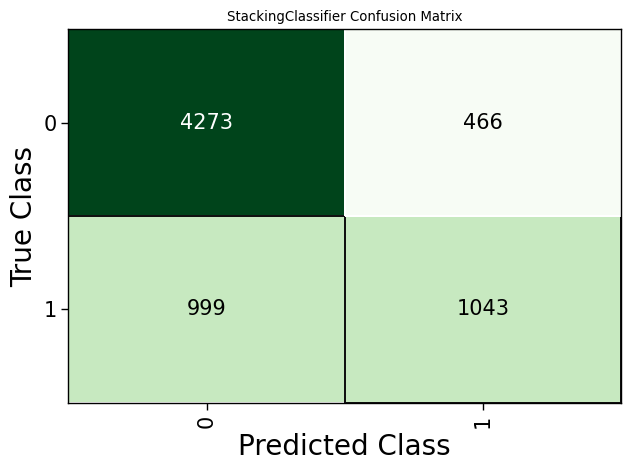

In [79]:
pyc.plot_model(tuned_radio_clf, plot='confusion_matrix')

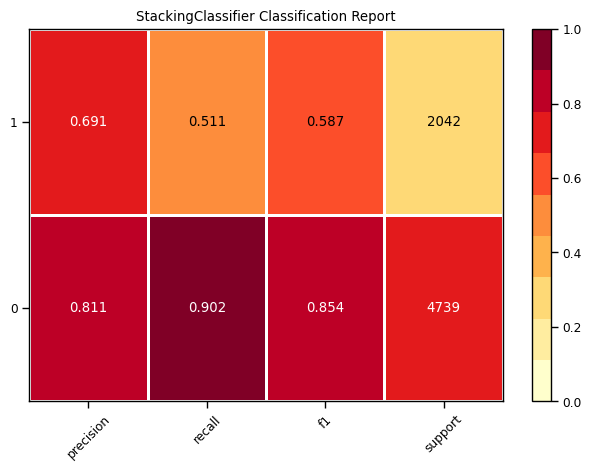

In [80]:
pyc.plot_model(tuned_radio_clf, plot='class_report')

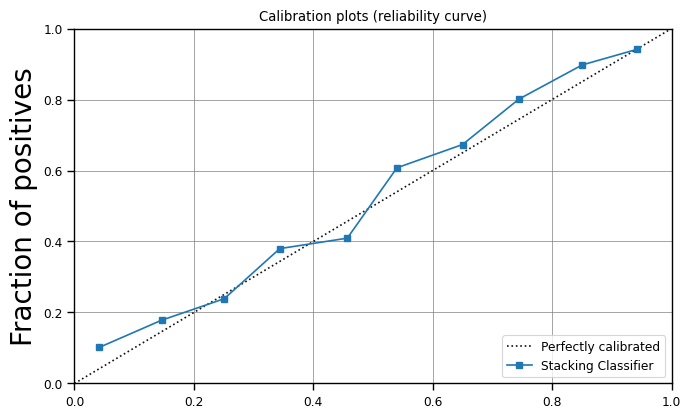

In [81]:
pyc.plot_model(tuned_radio_clf, plot='calibration')

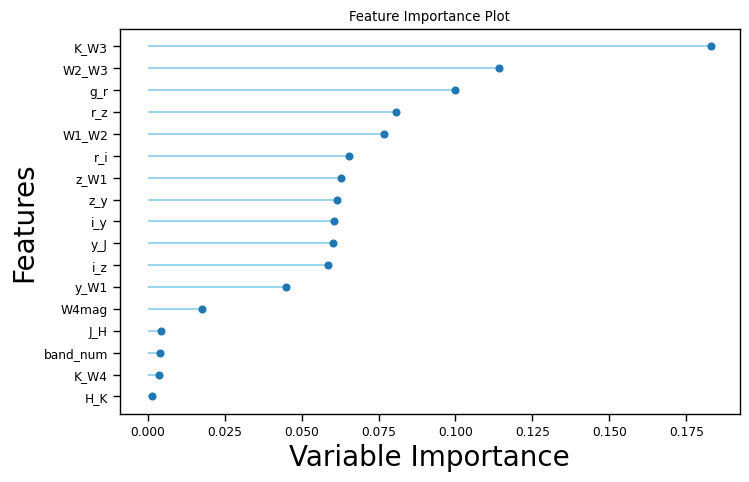

In [82]:
pyc.plot_model(tuned_radio_clf.estimators_[0], plot='feature_all')

In [83]:
pyc.plot_model(tuned_radio_clf.final_estimator, plot='parameter')

,Parameters
depth,7
l2_leaf_reg,7
border_count,254
thread_count,12
verbose,False
random_strength,0.8
task_type,CPU
n_estimators,210
random_state,42
eta,0.0001


In [84]:
plt.rcParams.update(plt.rcParamsDefault)

In [85]:
pyc.predict_model(tuned_radio_clf, probability_threshold=0.5, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.7840,0.7980,0.5108,0.6912,0.5874,0.4455,0.4549


,band_num,W4mag,g_r,r_i,r_z,i_z,i_y,z_y,z_W1,y_J,...,J_H,H_K,K_W3,K_W4,W1_W2,W2_W3,radio_detect,Label,Score_0,Score_1
0,0.253330,0.257732,-0.262176,-0.572816,-0.399997,-0.003791,0.338775,0.292266,-1.453140,-0.395352,...,-0.032527,0.181201,-0.292387,-0.059295,-0.269962,0.631585,1,0,0.5013,0.4987
1,-1.676841,0.257732,-0.150143,-0.011825,0.689111,0.866846,-0.881590,-1.509251,-0.220594,1.279209,...,-0.032527,0.181201,-0.292387,-0.059295,-0.546319,1.098160,0,0,0.5115,0.4885
2,0.253330,0.257732,1.218412,1.437143,1.352990,0.301332,0.998729,0.762962,0.725612,-0.130748,...,-0.032527,0.181201,-0.292387,-0.059295,-1.976840,0.423485,1,0,0.5030,0.4970
3,-1.676841,0.257732,-0.235896,0.070267,0.507977,0.555679,-0.680884,-1.098242,-0.340968,1.279209,...,-0.032527,0.181201,-0.292387,-0.059295,-0.105160,1.343233,0,0,0.5115,0.4885
4,0.253330,0.257732,-0.794796,0.230533,-0.076554,-0.305650,-0.425218,-0.232162,-0.562803,-1.074675,...,-0.032527,0.181201,1.673565,-0.059295,2.632751,-0.966060,1,1,0.4982,0.5018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6776,0.253330,0.257732,-0.433521,0.195264,-0.835524,-1.116367,0.376818,1.128664,0.775523,-0.141439,...,-0.032527,0.181201,-0.292387,-0.059295,-0.568849,-0.172947,0,0,0.5094,0.4906
6777,0.253330,0.257732,-0.274369,-0.982489,0.028292,0.850108,0.237275,-0.404456,-1.549620,-0.191903,...,-0.032527,0.181201,-0.292387,-0.059295,2.259472,-0.218743,0,0,0.5023,0.4977
6778,0.253330,0.257732,-0.286307,0.756121,1.219449,0.830693,1.410198,0.850638,0.947338,-0.267915,...,-0.032527,0.181201,-0.292387,-0.059295,-1.393849,-0.315898,0,0,0.5058,0.4942
6779,-1.676841,0.257732,0.054120,0.397724,0.004785,-0.360599,-1.263404,-0.963453,-0.231873,1.279209,...,-0.032527,0.181201,-0.292387,-0.059295,-0.105160,1.343233,0,0,0.5115,0.4885


In [86]:
test_prediction_clf = pyc.predict_model(tuned_radio_clf, probability_threshold=0.5, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.7840,0.7980,0.5108,0.6912,0.5874,0.4455,0.4549


In [87]:
final_radio_clf = pyc.finalize_model(tuned_radio_clf)

/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the a

In [88]:
if save_model_flag:
    # pyc.save_model(final_radio_clf, 'models/classification_radio_detect_may_16_2022')  # Model (it will be saved with .pkl extension)
    # pyc.save_config('models/config_classification_radio_detect_may_16_2022')  # Configuration file (with included predictions)
    pyc.save_model(final_radio_clf, 'models/classification_radio_detect_ago_02_2022')  # Model (it will be saved with .pkl extension)
    # pyc.save_config('models/config_classification_radio_detect_ago_02_2022')  # Configuration file

Transformation Pipeline and Model Successfully Saved


## Load Models

AGN detection model.

In [68]:
if load_model_flag:
    # final_radio_clf = pyc.load_model('models/classification_radio_detect_may_16_2022')
    final_radio_clf = pyc.load_model('models/classification_radio_detect_ago_02_2022')

Transformation Pipeline and Model Successfully Loaded


### Prediction process

#### Feature importances

In [69]:
estimators_list = get_base_estimators_names(final_radio_clf)

In [70]:
extended_data_radio = validation_df.loc[:, get_final_column_names(final_radio_clf, validation_df)].copy()
extended_idx_radio  = extended_data_radio.index
initial_cols_radio  = extended_data_radio.columns
extended_cols_radio = extended_data_radio.columns.insert(0, estimators_list[0])
if len(estimators_list) > 1:
    for est_name in estimators_list[1::]:
        extended_cols_radio = extended_cols_radio.insert(0, est_name)

Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names


In [71]:
print('Running data pre-processing:\n')
if isinstance(final_radio_clf, sklearn.pipeline.Pipeline):
    prep_steps = final_radio_clf.named_steps.items()
else:
    prep_steps = pyc.get_config('prep_pipe').named_steps.items()

for (name, method) in prep_steps:
    if method != 'passthrough':  # and name != 'trained_model':
        print(f'Running {name}')
        extended_data_radio = method.transform(extended_data_radio)
extended_data_radio_df = pd.DataFrame(extended_data_radio, columns=extended_cols_radio, index=extended_idx_radio)

Running data pre-processing:

Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names
Running trained_model


In [72]:
if isinstance(final_radio_clf, sklearn.pipeline.Pipeline):
    importances_coef = final_radio_clf.named_steps['trained_model'].final_estimator_.feature_importances_
else:
    importances_coef = final_radio_clf.final_estimator_.feature_importances_

coef_meta_df = pd.DataFrame({'Feature': extended_cols_radio, 'Importance': importances_coef})
coef_sorted_meta_df = (
    coef_meta_df.sort_values(by='Importance', ascending=False)
    .head(len(extended_cols_radio))
    .sort_values(by='Importance', ascending=False).reset_index(drop=True)
)

In [73]:
if isinstance(final_radio_clf, sklearn.pipeline.Pipeline):
    estimators_list  = final_radio_clf.named_steps['trained_model'].estimators
    estimators_list_ = final_radio_clf.named_steps['trained_model'].estimators_
else:
    estimators_list  = final_radio_clf.estimators
    estimators_list_ = final_radio_clf.estimators_

In [74]:
base_models_names = [model[0] for model in estimators_list]

In [75]:
coef_sorted_base_df = {}

In [76]:
for model, model_fit in zip(base_models_names, estimators_list_):
    if hasattr(model_fit, 'feature_importances_'):
        coef_base_df = pd.DataFrame({'Feature': extended_cols_radio.drop(base_models_names),
                                     'Importance': model_fit.feature_importances_})
        coef_sorted_base_df[model] = (
        coef_base_df.sort_values(by='Importance', ascending=False)
        .head(len(extended_cols_radio.drop(base_models_names)))
        .sort_values(by='Importance', ascending=False).reset_index(drop=True)
    )
    elif hasattr(model_fit, 'coef_'):
        coef_base_df = pd.DataFrame({'Feature': extended_cols_radio.drop(base_models_names),
                                     'Importance': np.abs(model_fit.coef_) *\
                                     extended_data_radio_df.loc[:, extended_cols_radio.drop(base_models_names)].std(axis=0)})
        coef_sorted_base_df[model] = (
        coef_base_df.sort_values(by='Importance', ascending=False)
        .head(len(extended_cols_radio.drop(base_models_names)))
        .sort_values(by='Importance', ascending=False).reset_index(drop=True)
)

In [77]:
multicol_feat = [(key, name) for key in coef_sorted_base_df.keys() for name in ('Feature', 'Importance')]

In [78]:
print('Feature importances scaled to sum 100')
coef_sorted_base_df_copy_sum = coef_sorted_base_df.copy()
for key in coef_sorted_base_df_copy_sum.keys():
    print(f'Calculating for {key}...')
    coef_sorted_base_df_copy_sum[key].loc[:, 'Importance'] = coef_sorted_base_df[key].loc[:, 'Importance'] /\
                                                        coef_sorted_base_df[key].loc[:, 'Importance'].sum() * 100
    # display(coef_sorted_base_df_copy_sum[key])
coef_sorted_base_full_df = pd.concat([coef_sorted_base_df_copy_sum[key].reset_index(drop=True) for key in coef_sorted_base_df_copy_sum.keys()], axis=1)
coef_sorted_base_full_df.columns = pd.MultiIndex.from_tuples(multicol_feat)
display(coef_sorted_base_full_df)

Feature importances scaled to sum 100
Calculating for dt...
Calculating for rf...
Calculating for lightgbm...
Calculating for xgboost...


dt                   rf             lightgbm              xgboost  \
     Feature Importance   Feature Importance   Feature Importance   Feature   
0       K_W3  18.318348     W2_W3  12.390435       g_r  10.833333      K_W3   
1      W2_W3  11.412378       y_J   9.476183     W1_W2  10.700000     W4mag   
2        g_r   9.997978      K_W3   8.924298     W2_W3   9.233333     W2_W3   
3        r_z   8.079615       g_r   8.475018       r_z   9.200000       y_J   
4      W1_W2   7.676316       r_z   7.351783       r_i   8.866667       g_r   
5        r_i   6.551827     W1_W2   7.155305      z_W1   8.266667       r_z   
6       z_W1   6.271167       r_i   7.019577       i_z   8.166667     W1_W2   
7        z_y   6.162421      z_W1   6.591085      y_W1   7.200000      y_W1   
8        i_y   6.056333       i_z   6.478711       y_J   5.933333       z_y   
9        y_J   6.014452      y_W1   6.461616       i_y   5.833333      z_W1   
10       i_z   5.864783       i_y   6.363623       z_y   5.800000  band_num   
11      y_W1   4.496307       z_y   6.274440      K_W3   4.400000       i_z   
12     W4mag   1.746512     W4mag   2.329460      K_W4   1.700000       r_i   
13       J_H   0.435548  band_num   2.101911     W4mag   1.366667      K_W4   
14  band_num   0.402963      K_W4   1.323293  band_num   1.166667       i_y   
15      K_W4   0.359461       H_K   0.804360       J_H   1.066667       H_K   
16       H_K   0.153590       J_H   0.478902       H_K   0.266667       J_H   

               
   Importance  
0   31.176790  
1   14.755308  
2    8.717365  
3    5.625892  
4    4.127072  
5    3.901536  
6    3.623841  
7    3.315265  
8    3.240804  
9    3.217515  
10   3.204003  
11   3.055652  
12   2.992154  
13   2.889510  
14   2.780662  
15   1.837797  
16   1.538832

In [79]:
print('Feature importances scaled to sum 100')
coef_sorted_meta_df_copy_sum = coef_sorted_meta_df.copy()
coef_sorted_meta_df_copy_sum.loc[:, 'Importance'] = coef_sorted_meta_df.loc[:, 'Importance'] /\
                                                     coef_sorted_meta_df.loc[:, 'Importance'].sum() * 100
print('Meta model')
display(coef_sorted_meta_df_copy_sum)

Feature importances scaled to sum 100
Meta model


,Feature,Importance
0,rf,44.681648
1,lightgbm,18.329611
2,W2_W3,7.998175
3,W4mag,6.499592
4,y_J,4.122712
5,K_W3,3.820407
6,dt,3.659922
7,g_r,1.583361
8,band_num,1.264076
9,K_W4,1.177708


Feature importances scaled to sum 100
Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names
--------------------
top features:
Feature	Importance
g_r	10.830
W1_W2	10.695
W2_W3	9.235
r_z	9.197
r_i	8.863
z_W1	8.264
i_z	8.164
y_W1	7.198
y_J	5.934
i_y	5.833
z_y	5.799
K_W3	4.415
K_W4	1.700
W4mag	1.372
band_num	1.167
J_H	1.066
H_K	0.267


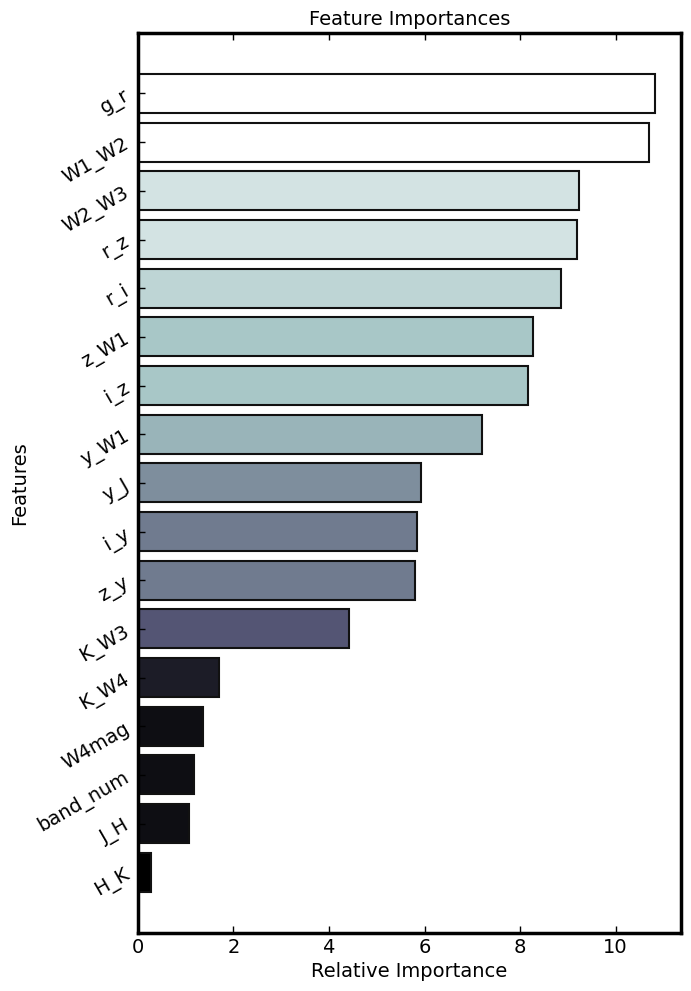

In [80]:
print('Feature importances scaled to sum 100')
try:
    fig         = plt.figure(figsize=(7,10))
    ax1         = fig.add_subplot(111)
    n_top       = len(validation_df.columns)
    features_df = get_feature_importances_df(final_radio_clf, validation_df, n=n_top)
    features    = features_df.loc[:, 'Feature'].to_list()
    importances = features_df.loc[:, 'Importance'].to_list()
    import_scal = importances / np.nansum(importances)
    import_scal_colors = (importances - np.nanmin(importances)) / (np.nanmax(importances) - np.nanmin(importances))
    # indices     = np.argsort(importances)[-n_top:] #only show most important features
    # indices     = np.argsort(importances)
    # ax1.set_title(f'{model_name} Feature Importances', size=14)
    ax1.set_title('Feature Importances', size=14)
    ax1.barh(range(len(importances)), import_scal * 100,\
             color=plt.get_cmap('bone', len(importances))(import_scal_colors), align='center', ec='k', lw=1.5)
    # plt.yticks(range(len(importances)), [features[i] for i in importances])
    plt.yticks(range(len(importances)), features)
    ax1.set_xlabel('Relative Importance', size=14)
    ax1.set_ylabel('Features', size=14)
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.tick_params(axis='y', which='major', rotation=30)
    plt.setp(ax1.spines.values(), linewidth=2.5)
    ax1.tick_params(which='both',top=True, right=False, direction='in')
    # ax1.set_xscale('log')
    # plt.show()
    plt.tight_layout()
    if save_plot_flag:
        plt.savefig('plots/feat_imp_classification_radio_detect_05.pdf', bbox_inches='tight')

    print('-' * 20)
    print('top features:')
    print('Feature\tImportance')
    for feat, imp in zip(reversed(features), reversed(import_scal  * 100)):
        print(f'{feat}\t{round(imp, 3):>.3f}')

except:
    print('learning algorithm does not provide feature importance.')

---

In [81]:
# train_size         = 0.7
# data_split_shuffle = True
# _stratify_columns = _get_columns_to_stratify_by(
#             train_test_df.drop(columns=['radio_detect']), train_test_df.loc[:, 'radio_detect'], False, 'radio_detect'
#         )
# 
# X_train, X_test, y_train, y_test = train_test_split(
#                 train_test_df.drop(columns=['radio_detect']),
#                 train_test_df.loc[:, 'radio_detect'],
#                 test_size=1 - train_size,
#                 stratify=_stratify_columns,
#                 random_state=seed,
#                 shuffle=data_split_shuffle,
#             )
# train_data_df        = pd.concat([X_train, y_train], axis=1)
# test_data_df         = pd.concat([X_test, y_test], axis=1)

In [82]:
print(f'Size of train set is {len(train_df):,}')
print(f'Size of test set is  {len(test_df):,}')

Size of train set is 15,820
Size of test set is  6,781


#### Calculate optimal threshold for classification

In [83]:
radio_naive_threshold       = 0.5

In [84]:
validation_prediction_clf = pyc.predict_model(final_radio_clf, data=validation_df, probability_threshold=radio_naive_threshold, raw_score=True, round=10)
train_prediction_clf      = pyc.predict_model(final_radio_clf, data=train_df,      probability_threshold=radio_naive_threshold, raw_score=True, round=10)
test_prediction_clf       = pyc.predict_model(final_radio_clf, data=test_df,       probability_threshold=radio_naive_threshold, raw_score=True, round=10)
train_test_prediction_clf = pyc.predict_model(final_radio_clf, data=train_test_df, probability_threshold=radio_naive_threshold, raw_score=True, round=10)

#### Naive threshold metrics.

In [85]:
cm_mat_val_naive = np.array([[np.sum(np.array(validation_prediction_clf['radio_detect'] == 0) & np.array(validation_prediction_clf['Label'] == 0)),\
                              np.sum(np.array(validation_prediction_clf['radio_detect'] == 0) & np.array(validation_prediction_clf['Label'] == 1))],\
                             [np.sum(np.array(validation_prediction_clf['radio_detect'] == 1) & np.array(validation_prediction_clf['Label'] == 0)),\
                              np.sum(np.array(validation_prediction_clf['radio_detect'] == 1) & np.array(validation_prediction_clf['Label'] == 1))]])

In [86]:
cm_mat_train_naive = np.array([[np.sum(np.array(train_prediction_clf['radio_detect'] == 0) & np.array(train_prediction_clf['Label'] == 0)),\
                                np.sum(np.array(train_prediction_clf['radio_detect'] == 0) & np.array(train_prediction_clf['Label'] == 1))],\
                               [np.sum(np.array(train_prediction_clf['radio_detect'] == 1) & np.array(train_prediction_clf['Label'] == 0)),\
                                np.sum(np.array(train_prediction_clf['radio_detect'] == 1) & np.array(train_prediction_clf['Label'] == 1))]])

In [87]:
cm_mat_test_naive = np.array([[np.sum(np.array(test_prediction_clf['radio_detect'] == 0) & np.array(test_prediction_clf['Label'] == 0)),\
                               np.sum(np.array(test_prediction_clf['radio_detect'] == 0) & np.array(test_prediction_clf['Label'] == 1))],\
                              [np.sum(np.array(test_prediction_clf['radio_detect'] == 1) & np.array(test_prediction_clf['Label'] == 0)),\
                               np.sum(np.array(test_prediction_clf['radio_detect'] == 1) & np.array(test_prediction_clf['Label'] == 1))]])

In [88]:
cm_mat_train_test_naive = np.array([[np.sum(np.array(train_test_prediction_clf['radio_detect'] == 0) & np.array(train_test_prediction_clf['Label'] == 0)),\
                                     np.sum(np.array(train_test_prediction_clf['radio_detect'] == 0) & np.array(train_test_prediction_clf['Label'] == 1))],\
                                    [np.sum(np.array(train_test_prediction_clf['radio_detect'] == 1) & np.array(train_test_prediction_clf['Label'] == 0)),\
                                     np.sum(np.array(train_test_prediction_clf['radio_detect'] == 1) & np.array(train_test_prediction_clf['Label'] == 1))]])

In [89]:
MCC_val_naive           = MCC_from_CM(cm_mat_val_naive)
ACC_val_naive           = ACC_from_CM(cm_mat_val_naive)
F1_val_naive            = F1_from_CM(cm_mat_val_naive)
Recall_val_naive        = Recall_from_CM(cm_mat_val_naive)

MCC_train_naive         = MCC_from_CM(cm_mat_train_naive)
ACC_train_naive         = ACC_from_CM(cm_mat_train_naive)
F1_train_naive          = F1_from_CM(cm_mat_train_naive)
Recall_train_naive      = Recall_from_CM(cm_mat_train_naive)

MCC_test_naive          = MCC_from_CM(cm_mat_test_naive)
ACC_test_naive          = ACC_from_CM(cm_mat_test_naive)
F1_test_naive           = F1_from_CM(cm_mat_test_naive)
Recall_test_naive       = Recall_from_CM(cm_mat_test_naive)

MCC_train_test_naive    = MCC_from_CM(cm_mat_train_test_naive)
ACC_train_test_naive    = ACC_from_CM(cm_mat_train_test_naive)
F1_train_test_naive     = F1_from_CM(cm_mat_train_test_naive)
Recall_train_test_naive = Recall_from_CM(cm_mat_train_test_naive)

naive_scores_array            = np.array([[F1_train_naive,      MCC_train_naive,      Recall_train_naive,      ACC_train_naive],\
                                          [F1_test_naive,       MCC_test_naive,       Recall_test_naive,       ACC_test_naive],\
                                          [F1_train_test_naive, MCC_train_test_naive, Recall_train_test_naive, ACC_train_test_naive],\
                                          [F1_val_naive,        MCC_val_naive,        Recall_val_naive,        ACC_val_naive]])

In [90]:
naive_scores_df = pd.DataFrame(data=naive_scores_array, columns=['F1', 'MCC', 'Recall', 'ACC'], index=['Train', 'Test', 'Train+Test', 'Validation'])

In [91]:
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(naive_scores_df)

,F1,MCC,Recall,ACC
Train,0.7832,0.7213,0.6832,0.8849
Test,0.5874,0.4549,0.5108,0.7840
Train+Test,0.7250,0.6419,0.6319,0.8546
Validation,0.5681,0.4430,0.4819,0.7844


In [92]:
validation_prediction_clf.loc[:, ['Score_0', 'Score_1']].describe()

,Score_0,Score_1
count,5650.000000,5650.000000
mean,0.505574,0.494426
std,0.006072,0.006072
min,0.487282,0.488079
25%,0.501727,0.489342
50%,0.507281,0.492719
75%,0.510658,0.498273
max,0.511921,0.512718


#### Calculate optimal threshold for prediction

Calculate ROC AUC values and plots.

In [93]:
roc_auc_train      = roc_auc_score(train_prediction_clf.loc[:, 'radio_detect'],      train_prediction_clf.loc[:, 'Score_1'])
roc_auc_test       = roc_auc_score(test_prediction_clf.loc[:, 'radio_detect'],       test_prediction_clf.loc[:, 'Score_1'])
roc_auc_train_test = roc_auc_score(train_test_prediction_clf.loc[:, 'radio_detect'], train_test_prediction_clf.loc[:, 'Score_1'])
roc_auc_validation = roc_auc_score(validation_prediction_clf.loc[:, 'radio_detect'], validation_prediction_clf.loc[:, 'Score_1'])

In [94]:
print(f'Area under the curve (ROC) for training   = {roc_auc_train:.5f}')
print(f'Area under the curve (ROC) for test       = {roc_auc_test:.5f}')
print(f'Area under the curve (ROC) for train+test = {roc_auc_train_test:.5f}')
print(f'Area under the curve (ROC) for validation = {roc_auc_validation:.5f}')

Area under the curve (ROC) for training   = 0.95600
Area under the curve (ROC) for test       = 0.79799
Area under the curve (ROC) for train+test = 0.91049
Area under the curve (ROC) for validation = 0.80199


In [95]:
fpr_train,      tpr_train,      thresh_train      = roc_curve(train_prediction_clf.loc[:, 'radio_detect'],      train_prediction_clf.loc[:, 'Score_1'])
fpr_test,       tpr_test,       thresh_test       = roc_curve(test_prediction_clf.loc[:, 'radio_detect'],       test_prediction_clf.loc[:, 'Score_1'])
fpr_train_test, tpr_train_test, thresh_train_test = roc_curve(train_test_prediction_clf.loc[:, 'radio_detect'], train_test_prediction_clf.loc[:, 'Score_1'])
fpr_val,        tpr_val,        thresh_val        = roc_curve(validation_prediction_clf.loc[:, 'radio_detect'], validation_prediction_clf.loc[:, 'Score_1'])

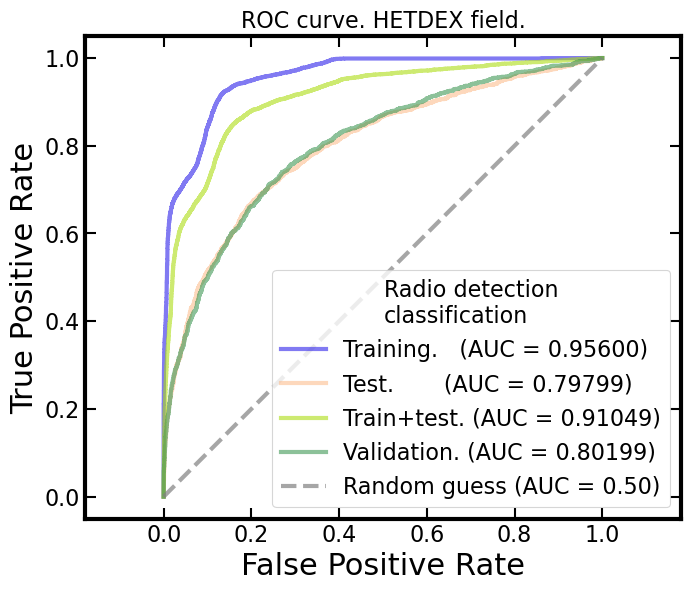

In [96]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

viz_train       = RocCurveDisplay(fpr=fpr_train,      tpr=tpr_train,      roc_auc=roc_auc_train)
viz_test        = RocCurveDisplay(fpr=fpr_test,       tpr=tpr_test,       roc_auc=roc_auc_test)
viz_train_test  = RocCurveDisplay(fpr=fpr_train_test, tpr=tpr_train_test, roc_auc=roc_auc_train_test)
viz_val         = RocCurveDisplay(fpr=fpr_val,        tpr=tpr_val,        roc_auc=roc_auc_validation)
viz_train.plot(ax=ax1,       lw=3, c=cm.get_cmap('cet_CET_C2s')(0.0), alpha=0.6, label=f"Training.   (AUC = {roc_auc_train:0.5f})")
viz_test.plot(ax=ax1,        lw=3, c=cm.get_cmap('cet_CET_C2s')(0.4), alpha=0.6, label=f"Test.       (AUC = {roc_auc_test:0.5f})")
viz_train_test.plot(ax=ax1,  lw=3, c=cm.get_cmap('cet_CET_C2s')(0.6), alpha=0.6, label=f"Train+test. (AUC = {roc_auc_train_test:0.5f})")
viz_val.plot(ax=ax1,         lw=3, c=cm.get_cmap('cet_CET_C2s')(0.8), alpha=0.6, label=f"Validation. (AUC = {roc_auc_validation:0.5f})")

ax1.plot([0, 1], [0, 1], ls='--', marker=None, c='Gray', alpha=0.7, lw=3.0, label='Random guess (AUC = 0.50)')

ax1.set_xlabel('False Positive Rate', fontsize=22)
ax1.set_ylabel('True Positive Rate', fontsize=22)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=3.0)
plt.setp(ax1.spines.values(), linewidth=3.0)
# ax1.set_aspect('equal', 'box')
plt.legend(loc=4, fontsize=16, title='Radio detection\nclassification', title_fontsize=16)
ax1.set_aspect('equal', 'datalim')
ax1.set_title('ROC curve. HETDEX field.', fontsize=16)
fig.tight_layout()
if save_plot_flag:
    plt.savefig('plots/AUC_ROC_classification_radio_detect_05.pdf', bbox_inches='tight')
plt.show()

##### Obtain optimal thresholds from each sub-set

In [97]:
opt_thres_train      = thresh_train[np.argmax(tpr_train - fpr_train)]
opt_thres_test       = thresh_test[np.argmax(tpr_test - fpr_test)]
opt_thres_train_test = thresh_train_test[np.argmax(tpr_train_test - fpr_train_test)]
opt_thres_validation = thresh_val[np.argmax(tpr_val - fpr_val)]

In [98]:
print(f'Optimal threshold from area under the curve (ROC) for training   = {opt_thres_train:.8e}')
print(f'Optimal threshold from area under the curve (ROC) for test       = {opt_thres_test:.8e}')
print(f'Optimal threshold from area under the curve (ROC) for train+test = {opt_thres_train_test:.8e}')
print(f'Optimal threshold from area under the curve (ROC) for validation = {opt_thres_validation:.8e}')

Optimal threshold from area under the curve (ROC) for training   = 4.95215049e-01
Optimal threshold from area under the curve (ROC) for test       = 4.95736190e-01
Optimal threshold from area under the curve (ROC) for train+test = 4.95373855e-01
Optimal threshold from area under the curve (ROC) for validation = 4.94647228e-01


##### Precision-Recall curve

In [99]:
prec_train,      recall_train,      thresh_train      = precision_recall_curve(train_prediction_clf.loc[:, 'radio_detect'],\
                                                                               train_prediction_clf.loc[:, 'Score_1'],      pos_label=1)
prec_test,       recall_test,       thresh_test       = precision_recall_curve(test_prediction_clf.loc[:, 'radio_detect'],\
                                                                               test_prediction_clf.loc[:, 'Score_1'],       pos_label=1)
prec_train_test, recall_train_test, thresh_train_test = precision_recall_curve(train_test_prediction_clf.loc[:, 'radio_detect'],\
                                                                               train_test_prediction_clf.loc[:, 'Score_1'], pos_label=1)
prec_validation, recall_validation, thresh_validation = precision_recall_curve(validation_prediction_clf.loc[:, 'radio_detect'],\
                                                                               validation_prediction_clf.loc[:, 'Score_1'], pos_label=1)

AUC for PR curve

In [100]:
auc_pr_train      = auc(recall_train,      prec_train)
auc_pr_test       = auc(recall_test,       prec_test)
auc_pr_train_test = auc(recall_train_test, prec_train_test)
auc_pr_validation = auc(recall_validation, prec_validation)

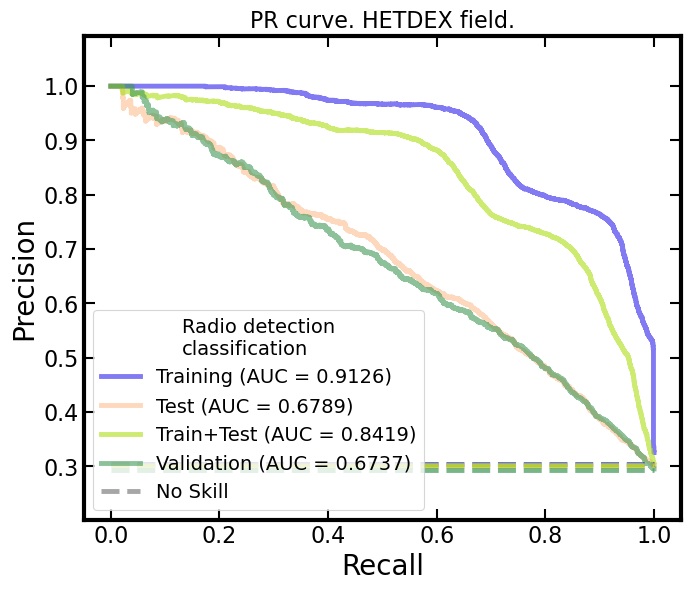

In [101]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

viz_train       = PrecisionRecallDisplay(precision=prec_train,      recall=recall_train)
viz_test        = PrecisionRecallDisplay(precision=prec_test,       recall=recall_test)
viz_train_test  = PrecisionRecallDisplay(precision=prec_train_test, recall=recall_train_test)
viz_val         = PrecisionRecallDisplay(precision=prec_validation, recall=recall_validation)
viz_train.plot(ax=ax1,       lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.0), alpha=0.6, label=f"Training (AUC = {auc_pr_train:.4f})")
viz_test.plot(ax=ax1,        lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.4), alpha=0.6, label=f"Test (AUC = {auc_pr_test:.4f})")
viz_train_test.plot(ax=ax1,  lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.6), alpha=0.6, label=f"Train+Test (AUC = {auc_pr_train_test:.4f})")
viz_val.plot(ax=ax1,         lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.8), alpha=0.6, label=f"Validation (AUC = {auc_pr_validation:.4f})")

no_skill_train      = np.sum(train_prediction_clf.loc[:, 'radio_detect'] == 1)      / len(train_prediction_clf.loc[:, 'radio_detect'])
no_skill_test       = np.sum(test_prediction_clf.loc[:, 'radio_detect'] == 1)       / len(test_prediction_clf.loc[:, 'radio_detect'])
no_skill_train_test = np.sum(train_test_prediction_clf.loc[:, 'radio_detect'] == 1) / len(train_test_prediction_clf.loc[:, 'radio_detect'])
no_skill_val        = np.sum(validation_prediction_clf.loc[:, 'radio_detect'] == 1) / len(validation_prediction_clf.loc[:, 'radio_detect'])
ax1.plot([0, 1], [no_skill_train,      no_skill_train],      ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.0), alpha=0.7, lw=3.5)
ax1.plot([0, 1], [no_skill_test,       no_skill_test],       ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.4), alpha=0.7, lw=3.5)
ax1.plot([0, 1], [no_skill_train_test, no_skill_train_test], ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.6), alpha=0.7, lw=3.5)
ax1.plot([0, 1], [no_skill_val,        no_skill_val],        ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.8), alpha=0.7, lw=3.5)
ax1.plot([1, 1], [1, 1], ls='--', marker=None, c='Gray', alpha=0.7, lw=3.5, label='No Skill', zorder=0)

# ax1.plot([0, 1], [0, 1], ls='--', marker=None, c='Gray', alpha=0.7, lw=3.0, label='Random guess (AUC = 0.50)')

ax1.set_xlabel('Recall', fontsize=20)
ax1.set_ylabel('Precision', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=3.0)
plt.setp(ax1.spines.values(), linewidth=3.0)
# ax1.set_aspect('equal', 'box')
plt.legend(loc=3, fontsize=14, title='Radio detection\nclassification', title_fontsize=14)
ax1.set_aspect('equal', 'datalim')
ax1.set_title('PR curve. HETDEX field.', fontsize=16)
fig.tight_layout()
if save_plot_flag:
    plt.savefig('plots/PR_curve_classification_radio_detect_05.pdf', bbox_inches='tight')
plt.show()

Find optimal threshold from PR curve

In [102]:
fscore_train      = (2 * prec_train      * recall_train)      / (prec_train      + recall_train)
fscore_test       = (2 * prec_test       * recall_test)       / (prec_test       + recall_test)
fscore_train_test = (2 * prec_train_test * recall_train_test) / (prec_train_test + recall_train_test)
fscore_validation = (2 * prec_validation * recall_validation) / (prec_validation + recall_validation)

In [103]:
opt_t_PR_train      = thresh_train[np.argmax(fscore_train)]
opt_t_PR_test       = thresh_test[np.argmax(fscore_test)]
opt_t_PR_train_test = thresh_train_test[np.argmax(fscore_train_test)]
opt_t_PR_validation = thresh_validation[np.argmax(fscore_validation)]

In [104]:
print(f'Optimal threshold from Precision-Recall curve for training   = {opt_t_PR_train:.8e}')
print(f'Optimal threshold from Precision-Recall curve for test       = {opt_t_PR_test:.8e}')
print(f'Optimal threshold from Precision-Recall curve for train+test = {opt_t_PR_train_test:.8e}')
print(f'Optimal threshold from Precision-Recall curve for validation = {opt_t_PR_validation:.8e}')

Optimal threshold from Precision-Recall curve for training   = 4.95506983e-01
Optimal threshold from Precision-Recall curve for test       = 4.95736190e-01
Optimal threshold from Precision-Recall curve for train+test = 4.95887005e-01
Optimal threshold from Precision-Recall curve for validation = 4.94647228e-01


#### Calibration curve

In [105]:
fract_positiv_train_test, mean_pred_val_train_test =\
                        calibration_curve(train_test_prediction_clf.loc[:, 'radio_detect'],\
                                          train_test_prediction_clf.loc[:, 'Score_1'],\
                                          n_bins=20, normalize=True)  # calibration_curve(y_test, prob_pos, n_bins=10)

fract_positiv_val, mean_pred_val_val =\
                        calibration_curve(validation_prediction_clf.loc[:, 'radio_detect'],\
                                          validation_prediction_clf.loc[:, 'Score_1'],\
                                          n_bins=20, normalize=True)  # calibration_curve(y_test, prob_pos, n_bins=10)

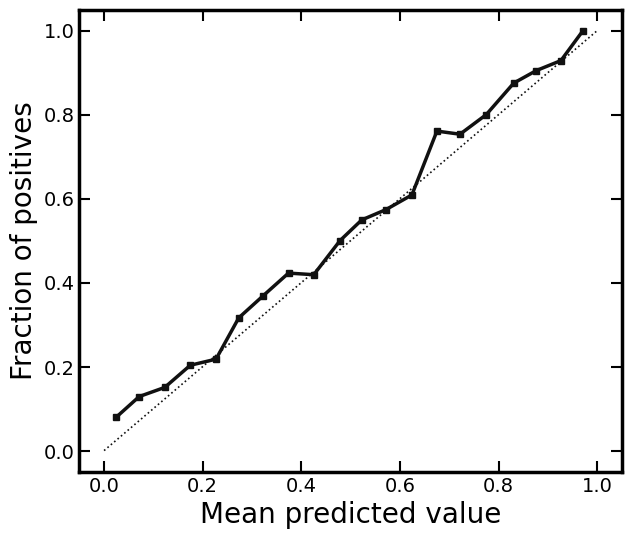

In [106]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

ax1.plot(mean_pred_val_val, fract_positiv_val, ls='-', marker='s', c='k', lw=2.5)
ax1.plot([0, 1], [0, 1], ls=':', c='k', label="Perfectly calibrated")
ax1.set_xlabel('Mean predicted value', fontsize=20)
ax1.set_ylabel('Fraction of positives', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.show()

---

In [107]:
radio_pred_threshold = float(opt_t_PR_train_test) # 0.5

In [108]:
validation_prediction_clf = pyc.predict_model(final_radio_clf, data=validation_df, probability_threshold=radio_pred_threshold, raw_score=True, round=10)
train_prediction_clf      = pyc.predict_model(final_radio_clf, data=train_df,      probability_threshold=radio_pred_threshold, raw_score=True, round=10)
test_prediction_clf       = pyc.predict_model(final_radio_clf, data=test_df,       probability_threshold=radio_pred_threshold, raw_score=True, round=10)
train_test_prediction_clf = pyc.predict_model(final_radio_clf, data=train_test_df, probability_threshold=radio_pred_threshold, raw_score=True, round=10)

Create confusion matrices.

In [109]:
cm_mat_val = np.array([[np.sum(np.array(validation_prediction_clf['radio_detect'] == 0) & np.array(validation_prediction_clf['Label'] == 0)),\
                        np.sum(np.array(validation_prediction_clf['radio_detect'] == 0) & np.array(validation_prediction_clf['Label'] == 1))],\
                       [np.sum(np.array(validation_prediction_clf['radio_detect'] == 1) & np.array(validation_prediction_clf['Label'] == 0)),\
                        np.sum(np.array(validation_prediction_clf['radio_detect'] == 1) & np.array(validation_prediction_clf['Label'] == 1))]])

cm_mat_train = np.array([[np.sum(np.array(train_prediction_clf['radio_detect'] == 0) & np.array(train_prediction_clf['Label'] == 0)),\
                          np.sum(np.array(train_prediction_clf['radio_detect'] == 0) & np.array(train_prediction_clf['Label'] == 1))],\
                         [np.sum(np.array(train_prediction_clf['radio_detect'] == 1) & np.array(train_prediction_clf['Label'] == 0)),\
                          np.sum(np.array(train_prediction_clf['radio_detect'] == 1) & np.array(train_prediction_clf['Label'] == 1))]])

cm_mat_test = np.array([[np.sum(np.array(test_prediction_clf['radio_detect'] == 0) & np.array(test_prediction_clf['Label'] == 0)),\
                         np.sum(np.array(test_prediction_clf['radio_detect'] == 0) & np.array(test_prediction_clf['Label'] == 1))],\
                        [np.sum(np.array(test_prediction_clf['radio_detect'] == 1) & np.array(test_prediction_clf['Label'] == 0)),\
                         np.sum(np.array(test_prediction_clf['radio_detect'] == 1) & np.array(test_prediction_clf['Label'] == 1))]])

cm_mat_train_test = np.array([[np.sum(np.array(train_test_prediction_clf['radio_detect'] == 0) & np.array(train_test_prediction_clf['Label'] == 0)),\
                               np.sum(np.array(train_test_prediction_clf['radio_detect'] == 0) & np.array(train_test_prediction_clf['Label'] == 1))],\
                              [np.sum(np.array(train_test_prediction_clf['radio_detect'] == 1) & np.array(train_test_prediction_clf['Label'] == 0)),\
                               np.sum(np.array(train_test_prediction_clf['radio_detect'] == 1) & np.array(train_test_prediction_clf['Label'] == 1))]])

In [110]:
MCC_radio_train    = MCC_from_CM(cm_mat_train)
ACC_radio_train    = ACC_from_CM(cm_mat_train)
F1_radio_train     = F1_from_CM(cm_mat_train)
Recall_radio_train = Recall_from_CM(cm_mat_train)

MCC_radio_test    = MCC_from_CM(cm_mat_test)
ACC_radio_test    = ACC_from_CM(cm_mat_test)
F1_radio_test     = F1_from_CM(cm_mat_test)
Recall_radio_test = Recall_from_CM(cm_mat_test)

MCC_radio_train_test    = MCC_from_CM(cm_mat_train_test)
ACC_radio_train_test    = ACC_from_CM(cm_mat_train_test)
F1_radio_train_test     = F1_from_CM(cm_mat_train_test)
Recall_radio_train_test = Recall_from_CM(cm_mat_train_test)

MCC_radio_val    = MCC_from_CM(cm_mat_val)
ACC_radio_val    = ACC_from_CM(cm_mat_val)
F1_radio_val     = F1_from_CM(cm_mat_val)
Recall_radio_val = Recall_from_CM(cm_mat_val)

radio_scores_array      = np.array([[F1_radio_train,      MCC_radio_train,      Recall_radio_train,      ACC_radio_train],\
                                    [F1_radio_test,       MCC_radio_test,       Recall_radio_test,       ACC_radio_test],\
                                    [F1_radio_train_test, MCC_radio_train_test, Recall_radio_train_test, ACC_radio_train_test],\
                                    [F1_radio_val,        MCC_radio_val,        Recall_radio_val,        ACC_radio_val]])

In [111]:
radio_scores_array_df = pd.DataFrame(data=radio_scores_array, columns=['F1', 'MCC', 'Recall', 'ACC'], index=['Train', 'Test', 'Train+Test', 'Validation'])

In [112]:
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(radio_scores_array_df)

,F1,MCC,Recall,ACC
Train,0.8267,0.7473,0.9017,0.8850
Test,0.6276,0.4545,0.6685,0.7611
Train+Test,0.7684,0.6603,0.8323,0.8478
Validation,0.6124,0.4430,0.6354,0.7634


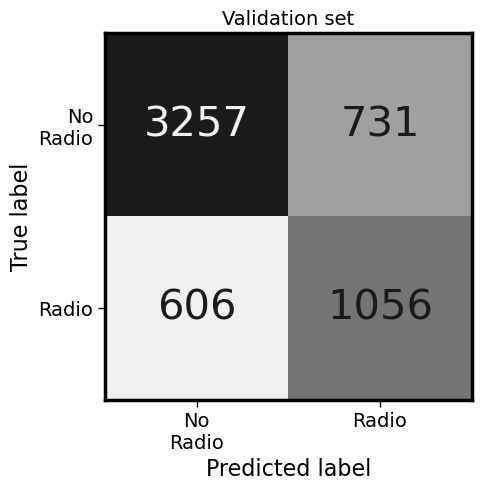

In [113]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

plot_conf_mat(cm_mat_val, title='Validation set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=False)
plt.tight_layout()
if save_plot_flag:
    plt.savefig('plots/conf_matrix_validation_classification_radio_detect_05.pdf', bbox_inches='tight')
plt.show()

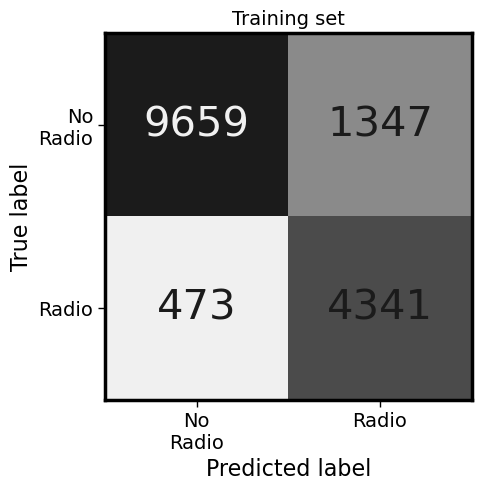

In [114]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
plot_conf_mat(cm_mat_train, title='Training set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=False)
plt.tight_layout()
if save_plot_flag:
    plt.savefig('plots/conf_matrix_train_classification_radio_detect_05.pdf', bbox_inches='tight')
plt.show()

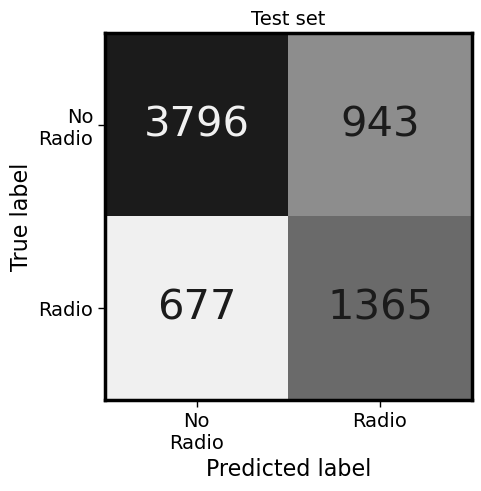

In [115]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
plot_conf_mat(cm_mat_test, title='Test set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=False)
plt.tight_layout()
if save_plot_flag:
    plt.savefig('plots/conf_matrix_test_classification_radio_detect_05.pdf', bbox_inches='tight')
plt.show()

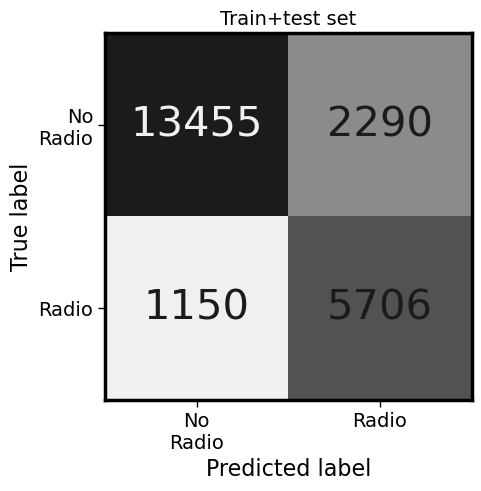

In [116]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
plot_conf_mat(cm_mat_train_test, title='Train+test set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=False)
plt.tight_layout()
if save_plot_flag:
    plt.savefig('plots/conf_matrix_train_test_classification_radio_detect_05.pdf', bbox_inches='tight')
plt.show()

### Calibrate model and save it separately

In [117]:
extended_train_test      = validation_df.loc[:, get_final_column_names(final_radio_clf, validation_df)].copy()
extended_idx_train_test  = extended_train_test.index
initial_cols             = extended_train_test.columns
extended_cols_train_test = extended_train_test.columns.insert(0, estimators_list[0])
if len(estimators_list) > 1:
    for est_name in estimators_list[1::]:
        extended_cols_train_test = extended_cols_train_test.insert(0, est_name)
        
print('Running data pre-processing:\n')
if isinstance(final_radio_clf, sklearn.pipeline.Pipeline):
    prep_steps = final_radio_clf.named_steps.items()
else:
    prep_steps = pyc.get_config('prep_pipe').named_steps.items()

for (name, method) in prep_steps:
    if method != 'passthrough':  # and name != 'trained_model':
        print(f'Running {name}')
        extended_train_test = method.transform(extended_train_test)
extended_train_test_df = pd.DataFrame(extended_train_test, columns=extended_cols_train_test, index=extended_idx_train_test)

Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names
Running data pre-processing:

Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names
Running trained_model


In [120]:
calibrated_final_radio_clf = CalibratedClassifierCV(base_estimator=final_radio_clf.named_steps['trained_model'], cv='prefit')
calibrated_final_radio_clf.fit(validation_df.loc[:, initial_cols], validation_df.loc[:, 'radio_detect'])

Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names


CalibratedClassifierCV(base_estimator=StackingClassifier(cv=5,
                                                         estimators=[('dt',
                                                                      DecisionTreeClassifier(random_state=42)),
                                                                     ('rf',
                                                                      RandomForestClassifier(n_jobs=12,
                                                                                             random_state=42)),
                                                                     ('lightgbm',
                                                                      LGBMClassifier(n_jobs=12,
                                                                                     random_state=42)),
                                                                     ('xgboost',
                                                                      XGBClassifier(base_score

In [126]:
pred_cal_prob_train      = calibrated_final_radio_clf.predict_proba(train_df.loc[:, initial_cols])[:, 1]
pred_cal_prob_test       = calibrated_final_radio_clf.predict_proba(test_df.loc[:, initial_cols])[:, 1]
pred_cal_prob_train_test = calibrated_final_radio_clf.predict_proba(train_test_df.loc[:, initial_cols])[:, 1]
pred_cal_prob_validation = calibrated_final_radio_clf.predict_proba(validation_df.loc[:, initial_cols])[:, 1]

##### Obtain optimal thresholds from train+test in calibrated model

##### Precision-Recall curve

In [127]:
prec_train_cal,      recall_train_cal,      thresh_train_cal      = precision_recall_curve(train_prediction_clf.loc[:, 'radio_detect'],\
                                                                               pred_cal_prob_train,      pos_label=1)
prec_test_cal,       recall_test_cal,       thresh_test_cal       = precision_recall_curve(test_prediction_clf.loc[:, 'radio_detect'],\
                                                                               pred_cal_prob_test,       pos_label=1)
prec_train_test_cal, recall_train_test_cal, thresh_train_test_cal = precision_recall_curve(train_test_prediction_clf.loc[:, 'radio_detect'],\
                                                                               pred_cal_prob_train_test, pos_label=1)
prec_validation_cal, recall_validation_cal, thresh_validation_cal = precision_recall_curve(validation_prediction_clf.loc[:, 'radio_detect'],\
                                                                               pred_cal_prob_validation, pos_label=1)

AUC for PR curve

In [128]:
auc_pr_train_cal      = auc(recall_train_cal,      prec_train_cal)
auc_pr_test_cal       = auc(recall_test_cal,       prec_test_cal)
auc_pr_train_test_cal = auc(recall_train_test_cal, prec_train_test_cal)
auc_pr_validation_cal = auc(recall_validation_cal, prec_validation_cal)

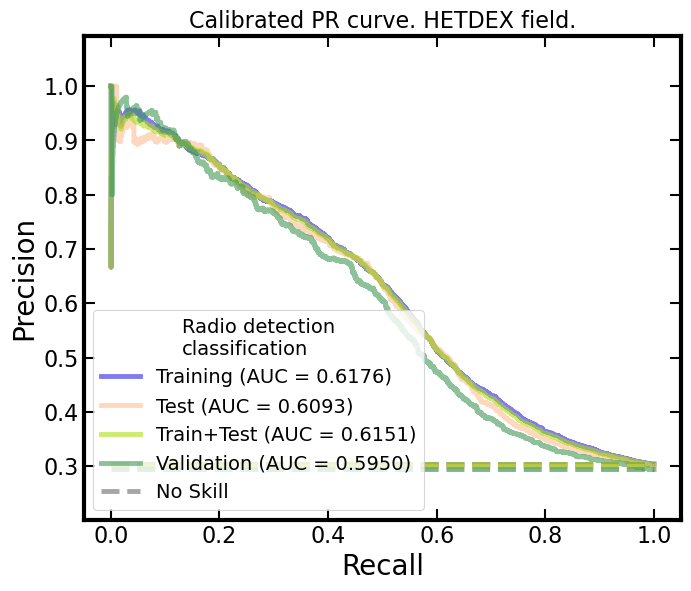

In [142]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

viz_train       = PrecisionRecallDisplay(precision=prec_train_cal,      recall=recall_train_cal)
viz_test        = PrecisionRecallDisplay(precision=prec_test_cal,       recall=recall_test_cal)
viz_train_test  = PrecisionRecallDisplay(precision=prec_train_test_cal, recall=recall_train_test_cal)
viz_val         = PrecisionRecallDisplay(precision=prec_validation_cal, recall=recall_validation_cal)
viz_train.plot(ax=ax1,       lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.0), alpha=0.6, label=f"Training (AUC = {auc_pr_train_cal:.4f})")
viz_test.plot(ax=ax1,        lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.4), alpha=0.6, label=f"Test (AUC = {auc_pr_test_cal:.4f})")
viz_train_test.plot(ax=ax1,  lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.6), alpha=0.6, label=f"Train+Test (AUC = {auc_pr_train_test_cal:.4f})")
viz_val.plot(ax=ax1,         lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.8), alpha=0.6, label=f"Validation (AUC = {auc_pr_validation_cal:.4f})")

no_skill_train      = np.sum(train_prediction_clf.loc[:, 'radio_detect'] == 1)      / len(train_prediction_clf.loc[:, 'radio_detect'])
no_skill_test       = np.sum(test_prediction_clf.loc[:, 'radio_detect'] == 1)       / len(test_prediction_clf.loc[:, 'radio_detect'])
no_skill_train_test = np.sum(train_test_prediction_clf.loc[:, 'radio_detect'] == 1) / len(train_test_prediction_clf.loc[:, 'radio_detect'])
no_skill_val        = np.sum(validation_prediction_clf.loc[:, 'radio_detect'] == 1) / len(validation_prediction_clf.loc[:, 'radio_detect'])
ax1.plot([0, 1], [no_skill_train,      no_skill_train],      ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.0), alpha=0.7, lw=3.5)
ax1.plot([0, 1], [no_skill_test,       no_skill_test],       ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.4), alpha=0.7, lw=3.5)
ax1.plot([0, 1], [no_skill_train_test, no_skill_train_test], ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.6), alpha=0.7, lw=3.5)
ax1.plot([0, 1], [no_skill_val,        no_skill_val],        ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.8), alpha=0.7, lw=3.5)
ax1.plot([1, 1], [1, 1], ls='--', marker=None, c='Gray', alpha=0.7, lw=3.5, label='No Skill', zorder=0)

# ax1.plot([0, 1], [0, 1], ls='--', marker=None, c='Gray', alpha=0.7, lw=3.0, label='Random guess (AUC = 0.50)')

ax1.set_xlabel('Recall', fontsize=20)
ax1.set_ylabel('Precision', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=3.0)
plt.setp(ax1.spines.values(), linewidth=3.0)
# ax1.set_aspect('equal', 'box')
plt.legend(loc=3, fontsize=14, title='Radio detection\nclassification', title_fontsize=14)
ax1.set_aspect('equal', 'datalim')
ax1.set_title('Calibrated PR curve. HETDEX field.', fontsize=16)
fig.tight_layout()
if save_plot_flag:
    plt.savefig('plots/PR_cal_curve_classification_radio_detect_05.pdf', bbox_inches='tight')
plt.show()

Find optimal threshold from PR curve

In [130]:
fscore_train_cal      = (2 * prec_train_cal      * recall_train_cal)      / (prec_train_cal      + recall_train_cal)
fscore_test_cal       = (2 * prec_test_cal       * recall_test_cal)       / (prec_test_cal       + recall_test_cal)
fscore_train_test_cal = (2 * prec_train_test_cal * recall_train_test_cal) / (prec_train_test_cal + recall_train_test_cal)
fscore_validation_cal = (2 * prec_validation_cal * recall_validation_cal) / (prec_validation_cal + recall_validation_cal)

In [136]:
opt_t_PR_train_cal      = thresh_train_cal[np.argmax(fscore_train_cal)]
opt_t_PR_test_cal       = thresh_test_cal[np.argmax(fscore_test_cal)]
opt_t_PR_train_test_cal = thresh_train_test_cal[np.argmax(fscore_train_test_cal)]
opt_t_PR_validation_cal = thresh_validation_cal[np.argmax(fscore_validation_cal)]

In [137]:
print('Otimal thresholds from calibrated Precision-Recal curves:')
print(f'Optimal threshold from Precision-Recall curve for training   = {opt_t_PR_train_cal:.5f}')
print(f'Optimal threshold from Precision-Recall curve for test       = {opt_t_PR_test_cal:.5f}')
print(f'Optimal threshold from Precision-Recall curve for train+test = {opt_t_PR_train_test_cal:.5f}')
print(f'Optimal threshold from Precision-Recall curve for validation = {opt_t_PR_validation_cal:.5f}')

Otimal thresholds from calibrated Precision-Recal curves:
Optimal threshold from Precision-Recall curve for training   = 0.25287
Optimal threshold from Precision-Recall curve for test       = 0.25503
Optimal threshold from Precision-Recall curve for train+test = 0.25453
Optimal threshold from Precision-Recall curve for validation = 0.25589


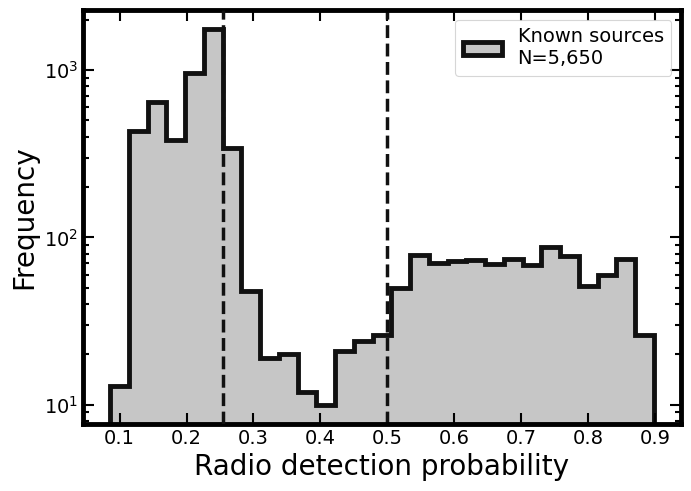

In [138]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score  = np.nanmin(pred_cal_prob_validation)
max_score  = np.nanmax(pred_cal_prob_validation)
score_bins = np.linspace(min_score, max_score, 30)

sample_size = len(pred_cal_prob_validation)

ax1.hist(pred_cal_prob_validation, bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=1.0, label=f'Known sources\nN={sample_size:,}')

ax1.axvline(x=0.5, ls='--', c='k', lw=2.5)
ax1.axvline(x=opt_t_PR_train_test_cal, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Radio detection probability', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(f'plots/hist_predicted_radio_cal_scores_pred_AGN_known.pdf', bbox_inches='tight')
plt.show()

In [139]:
if save_model_flag:
    dump(calibrated_final_radio_clf, 'models/cal_classification_radio_detect_ago_02_2022.joblib')

In [140]:
# if load_model_flag:
#     clf_test = load('models/cal_classification_radio_detect_ago_02_2022.joblib')

In [141]:
# clf_test.predict_proba(validation_df.loc[:, get_final_column_names(final_radio_clf, validation_df)])